# 第11章 强化微调

## 11.1 简介：为何用强化微调提升推理能力

强化学习 (Reinforcement Learning, RL) 是一种机器学习方法，智能体通过与环境的交互，学习如何在不同状态下采取行动，以最大化长期累积的奖励，进而提升智能体的序贯决策性能。与监督学习不同，强化学习不依赖于标注数据，而是通过试错和反馈机制来优化决策策略。

在过去的语言模型训练过程中，有监督学习（Supervised Fine-Tuning, SFT）长期被作为主流范式，用于微调模型的输出行为。但在诸多需要复杂逻辑推理的任务中，SFT 的能力提升逐渐遭遇瓶颈，难以通过单纯的数据对齐继续获得显著性能增益。近年来，越来越多的研究指出，将强化学习引入语言模型微调流程，能够有效提升模型在推理类任务中的表现。例如，DeepSeek-R1 和 Qwen-QwQ 等工作均表明，相较于仅使用 SFT，进一步引入强化微调可在数学推理等任务上额外提升 10–15 个百分点的准确率2504.16129v3。

强化学习的核心优势在于其“试错式”的能力塑造机制。与需要人工标注偏好得分的 RLHF 方法不同，强化微调中的奖励信号可以直接围绕“推理是否正确”展开，允许模型在环境交互中自主学习优化行为策略。这使得强化微调成为一种兼具效率与目标导向性的推理能力塑造手段，尤其适用于代码生成、数学解题、复杂指令执行等任务。

相比 SFT 主要依赖静态监督数据，强化微调支持模型在动态环境中进行决策，并根据实际反馈信号（如答案正确性、工具调用是否成功）调整策略。这种“奖励驱动的能力对齐”策略，更贴合推理任务的本质，能显著缓解样本稀疏、错误信号不明确等问题。

本章节将围绕上述背景展开，指导读者如何将任意推理任务建模为一个强化学习/强化微调问题，并逐步掌握四类主流算法（PPO、GRPO、DAPO、VAPO）的原理、实现与调参技巧。

## 11.2 将文本生成建模为 MDP

为了将推理类任务纳入强化学习框架，我们需首先将语言模型的生成过程形式化为一个马尔可夫决策过程（Markov Decision Process, MDP）或其部分可观测扩展（POMDP）。这种建模不仅为强化微调提供了数学基础，也为后续算法设计（如状态表示、奖励传递、策略更新）提供了统一视角。

<figure style="text-align: center;">
    <img src="png_chap11/MDP.png">
    <figcaption style="font-size: 0.9em; margin-top: 8px;">
    图1：一个简单的MDP示例，包含三个状态（绿色圆圈）和两个动作（橙色圆圈），以及两个奖励（橙色箭头）。
    </figcaption>
</figure>

### 文本生成的基本 MDP 建模

在语言模型中，生成过程可自然建模为一个序列决策过程，其每一步生成一个 token，构成一个标准的 MDP：

* **状态 $s_t$**：状态空间 $\mathcal{S}$，例如在语言模型中可以表示为当前对话的历史记录或任务的进展状态；
* **动作 $a_t$**：动作空间 $\mathcal{A} \subset \mathcal{V}^N$，其中 $\mathcal{V}$ 是词表空间，例如若模型的词表包含约50,000个token，每个动作就是从这个词表中选择下一个token；
* **目标空间 $\mathcal{G} \subset \mathcal{V}^N$**：给出了奖励的条件，例如在数学问题求解中，目标可以是正确的答案或解题步骤；
* **转移函数 $\mathcal{T}: \mathcal{S} \times \mathcal{A} \mapsto \mathcal{S}$**：状态转移函数，在语言模型中通常是将选择的token $a_t$ 拼接到当前上下文 $s_t$ 得到新的状态 $s_{t+1}$；
* **奖励函数 $\mathcal{R}: \mathcal{S} \times \mathcal{A} \times \mathcal{G} \mapsto \mathbb{R}$**：目标条件下的奖励函数，例如在代码生成任务中，可以根据生成代码是否编译成功、是否通过测试用例来给予奖励；
* **观测函数 $\mathcal{O}: \mathcal{S} \mapsto \mathcal{V}^N$**：将状态映射到文本描述的观测函数，例如模型接收到的环境输出，如问题描述、API返回结果或工具调用的反馈；
* **折扣因子 $\gamma$**：折扣因子，用于平衡即时奖励与长期收益，通常设置为接近1的值（如0.99）以鼓励长期规划。

这种建模方式在语言任务中通常被称为**语言增强 POMDP（Language-augmented POMDP）**。

<figure style="text-align: center;">
    <img src="png_chap11/lang-aug-mdp.jpg">
    <figcaption style="font-size: 0.9em; margin-top: 8px;">
    图2：在语言增强的POMDP中一次轨迹生成的示意图。
    </figcaption>
</figure>

### 状态-动作-奖励的结构特点

* **观察空间 $\mathcal{O}$ 与状态空间 $\mathcal{S}$ 本质上为自然语言序列**，如模型当前看到的问题、历史生成内容等；
* **动作 $a_t$** 通常为 vocabulary $V$ 中的 token，但也可以映射为函数调用、API 执行或代码片段输出；
* **奖励函数 $R(s_t, a_t)$** 可依据最终输出结果是否正确、输出是否规范、程序执行是否成功等标准设定。


### 大模型如何“给出”策略

传统 RL 要么手动设计网络结构输出动作分布，要么在网络尾部加上一个动作头（MLP）；而在大模型（LLM）中，我们直接利用它对“下一个 token”的概率分布来间接表示动作分布：

1. **Prompt 拼接**  
   将任务描述、当前观测、历史交互拼成一个长 prompt，输入给 LLM。

2. **令牌级概率（Token‐Level Probabilities）**  
   LLM 在每个位置 $j$ 都会给出下一个 token $w^j$ 的条件概率：  
   ```math
   P_{\mathrm{LLM}}(w_j \mid p, w_{<j})
   ```

3. **动作级概率（Sequence‐Level Probabilities）**  
   如果将某个完整动作 $a_i$ 定义为 token 序列 $a_i = (w^1, w^2, \dots, w^{|a_i|})$,
   那么 LLM 对该动作的（非归一化）log 概率就是：  
   ```math
   \log P_{\mathrm{LLM}}(a_i \mid p)
     = \sum_{j=1}^{|a_i|} \log P_{\mathrm{LLM}}(w^j \mid p, w^{<j})
   ```

4. **Softmax‐归一化**  
   为了让这些动作概率和为 1，我们对所有可行动作集合 $\mathcal{A}$ 做一次 softmax：  
   ```math
   \pi_\theta(a_i \mid p)
     = \frac{\exp\bigl(\log P_{\mathrm{LLM}}(a_i \mid p)\bigr)}
            {\sum_{a_j \in \mathcal{A}} \exp\bigl(\log P_{\mathrm{LLM}}(a_j \mid p)\bigr)}.
   ```  
   这样，LLM 本身“生成文本”的能力就被直接用来定义了策略 $\pi$。



### 更灵活的 Flex-POMDP 扩展

当语言模型参与到复杂任务环境（如多智能体协作、带外部工具调用的场景）中时，标准的语言增强 POMDP 显得力不从心。为此，MARFT 提出了一种更具通用性的建模框架——**Flexible POMDP (Flex-POMDP)**，其形式定义为：$\langle \mathcal{V}, \mathcal{N}, \mathcal{S}, \mathcal{O}, \mathcal{A}, \mathcal{T}, \mathcal{R}, \gamma, \mathcal{D} \rangle$。

<figure style="text-align: center;">
    <img src="png_chap11/flex-pomdp.jpg">
    <figcaption style="font-size: 0.9em; margin-top: 8px;">
    图1：Flex-POMDP 动态的详细示意图。依赖函数（虚线紫色线）可以随着时间步而变化。
    </figcaption>
</figure>


其中新增的关键元素是：

* **$\mathcal{N}$：智能体组成**，即多智能体系统中的智能体集合；
* **$\mathcal{D}(a_i, a_j)$：依赖函数**，定义某个智能体的动作是否依赖于另一智能体的结果（如 Reasoner → Actor）；
* **$\mathcal{V}$：词表集合**，支持异构智能体拥有各自的词表空间。

该模型允许智能体异步决策，体现出灵活的系统组织结构（如异步调用、层级规划、角色协作），特别适合推理链条长、任务结构复杂的语言智能体系统。



## 11.3 强化微调与强化学习

强化微调 (RFT) 是一种微调范式，它利用强化学习的能力来改进智能体的行为。虽然它与传统的强化学习有着一些基本相似之处，但 RFT 更加注重在特定任务中利用有限的高质量数据和有限的优化迭代次数来实现专家级的性能。

<figure style="text-align: center;">
    <img src="png_chap11/rft-vs-rl.jpg">
    <figcaption style="font-size: 0.9em; margin-top: 8px;">
    表 1 强化微调 (RFT) 与强化学习 (RL) 之间的区别
    </figcaption>
</figure>

强化学习与最优控制框架紧密相关，通常从头开始训练策略（例如机器人策略），无需任何先验领域知识。相比之下，强化微调基于大规模预训练模型，并根据特定任务进行调整。此外，强化学习专门针对特定环境中的特定任务训练策略，而强化微调则在增强模型的任务特定能力的同时，不会降低其原有能力，例如大语言模型中的语言理解能力。传统的强化学习环境是完全随机的，而典型的大语言模型强化微调代理性环境可以整合确定性和随机性转换——对于句子或 token 连接等操作是确定性的，对于环境反馈（例如工具执行结果或下一个用户查询）是随机的。由于大语言模型生成 token 来形成句子，因此其强化微调可以在动作级别（句子级别）和 token 级别运行，而传统的强化学习设置通常是动作级别。另一个主要区别是强化学习以其低样本效率而闻名，而强化微调需要相对较少的高质量样本。

既然我们了解了强化微调和强化学习之间的区别，我们就可以引入许多微调技术来更好地展示强化微调的工作原理以及许多现有研究中体现的内容。首先是 LoRA，它冻结基础模型，并将可训练的秩分解矩阵注入模型。LoRA 对于大语言模型的微调至关重要，尤其对于大语言模型多智能体系统，因为它能够以最少的参数更新有效地优化策略，并使基于大语言模型的多智能体训练变得经济实惠且理想。由于单个模型可以针对不同任务配备不同的 LoRA 适配器，因此可以仅使用配备多个适配器的基础模型来构建多智能体系统。其次，有必要在训练期间实施策略距离的约束，以防止策略更新偏离具有预训练能力的初始策略或参考策略过远。PPO 和其他信赖域相关算法为单调改进提供了强有力的保证，并且在它们的目标中，我们也可以将 KL 散度从$\pi_\text{old}$ 之间修改为 $\pi_\text{ref}$ 之间，就像 GRPO在损失函数中所做的那样。



## 11.4 Actor-Critic框架与PPO算法

### 11.4.1 基于价值的强化学习方法与基于策略的强化学习方法

在学习 AC框架和 PPO 算法之前，我们先了解一下基于价值的强化学习方法和基于策略的强化学习方法。

**基于价值的强化学习方法**：这类方法直接优化状态价值函数（或动作价值函数），通过与环境交互来更新价值函数的逼近。代表算法包括 Q-learning、DQN 等。重要的价值函数定义有：

$$Q^\pi(s_t, a_t) := \mathbb{E}_{\tau \sim p_\pi(\tau|s_t,a_t)} \left[ \sum_{t'=t}^{\infty} \gamma^{t'-t} r(s_{t'}, a_{t'}) \right] = \mathbb{E}_{(s,a)_{t+1:\infty}\sim p_\pi(s,a)} [G_t|s_t, a_t]$$

$$V^\pi(s_t) := \mathbb{E}_{\tau \sim p_\pi(\tau|s_t)} \left[ \sum_{t'=t}^{\infty} \gamma^{t'-t} r(s_{t'}, a_{t'}) \right] = \mathbb{E}_{a_t \sim \pi(a_t|s_t), (s,a)_{t+1:\infty}\sim p_\pi(s,a)} [G_t|s_t]$$

然后通过蒙特卡洛估计或者时间差分学习来估计价值函数。得到价值函数之后，下一个关键步骤就是策略提取。提取的具体策略可能因所选方法而异。例如，可以使用 $\pi(a_t|s_t) = \delta(a_t = \operatorname{argmax}_a Q(s_t, a))$ 提取贪婪策略，其中 $\delta$ 表示狄拉克函数。或者，软策略可以推导为 $\pi_{\text{MaxEnt}}(a_t|s_t) = \exp\left(\frac{1}{\alpha}(Q_{\text{soft}}(s_t, a_t) - V_{\text{soft}}(s_t))\right)$，其中 $\alpha$ 是温度参数。其他提取方法可以产生不同的策略，包括混合策略。

**基于策略的强化学习方法**：这类方法直接优化策略函数（或动作概率分布），通过与环境交互来更新策略。代表算法包括 REINFORCE等。该方法主要基于策略梯度定理（Policy Gradient Theorem）。回想一下，目标是最大化预期奖励$J(\theta) = \mathbb{E}_{_{\tau \sim p_{\pi_{\theta}}(\tau)}} \left[ \sum_{t=0}^{\infty} \gamma^{t} r(s_{t}, a_{t}) \right]$。根据策略梯度定理，预期奖励 $J(\theta)$ 的梯度可以表示为
$$\nabla_{\theta} J(\theta) = \mathbb{E}_{\tau \sim p_{\pi_{\theta}}(\tau)} \left[ \sum_{t=0}^{\infty} \Psi_{t} \nabla_{\theta} \log \pi_{\theta}(a_{t}|s_{t}) \right]$$
其中，在最简单的情况下，$\Psi_{t} = \sum_{t^\prime=t}^\infty\gamma^{t^\prime - t}r(s_{t^\prime}, a_{t^\prime})$。然而，累积折扣奖励通常难以直接获得，因此可以使用其他代理变量来近似计算 $\Psi_t$，例如 Q 值 $Q^\pi(s,a)$ 或优势函数 $A^\pi(s_t, a_t)$。给定 $J$ 相对于策略参数 $\theta$ 的梯度，我们就可以通过梯度上升法更新参数。

由此可见，策略梯度不再需要价值函数，而是直接利用真实奖励来优化策略。相比基于价值的方法，这种方法更加稳定，尤其是在策略为大语言模型的情况下。此外，还提出了许多其他变体，例如 REINFORCE++、RLOO等，它们在大语言模型智能体的训练中效果相对较好。

### 11.4.2 Actor-Critic 与 PPO

Actor-Critic (AC) 架构是一种混合方法，结合了基于价值的方法和基于策略的方法，用于优化策略。基于价值的方法提取策略的能力较差，而基于策略的方法缺乏对价值的直接估计，导致效率低下。Actor-Critic 继承了基于价值的方法的细粒度奖励归因能力，以及基于策略的方法的优化稳定性。Actor-Critic 算法以迭代方式训练价值函数和策略。对于每次迭代，它根据时间差分误差更新值函数，并通过策略梯度法优化策略。

最适合大语言模型的 AC 算法之一是近端策略优化（Proximal Policy Optimization, PPO），它基于信赖域策略优化（Trust-Region Policy Optimization, TRPO）开发。 TRPO 给出了一个要最大化的替代目标函数，并对策略更新步骤进行了约束，如下所示：

$$\text{maximize}_{\theta} \hat{\mathbb{E}}_t \left[ \frac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{\text{old}}}(a_t|s_t)} \hat{A}_t(s_t, a_t) \right], \ \mathrm{s.t.} \ \hat{\mathbb{E}}_t \left[ \text{KL} \left[ \pi_{\theta_{\text{old}}}(\cdot|s_t) \| \pi_{\theta}(\cdot|s_t) \right] \right] \leq \delta$$

其中 $\hat{A}_t$ 是时间步 $t$ 处优势函数的估计量，通常使用 GAE(Generalized Advantage Estimation)计算，$\hat{\mathbb{E}}_t$ 是有限批次样本的经验平均值。根据拉格朗日乘数，它等价于如下所示无约束问题：

$$\text{maximize}_{\theta} \hat{\mathbb{E}}_t \left[ \frac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{\text{old}}}(a_t|s_t)} \hat{A}_t(s_t,a_t) -\beta \text{KL} \left[ \pi_{\theta_{\text{old}}}(\cdot|s_t) \| \pi_{\theta}(\cdot|s_t) \right] \right]$$

TRPO 也为一般随机策略提供了单调改进保证，但对于上述优化目标，它涉及二阶优化，包括 Fisher 信息矩阵（Fisher Information Matrix, FIM）的计算，这可能代价高昂。基于 TRPO，PPO 作为一阶算法应运而生，它也能继承 TRPO 的单调改进。 PPO 提出裁剪后的替代优化目标如下：

$$\text{maximize}_{\theta} \hat{\mathbb{E}}_{t}\left[ \min \left( \frac{\pi_{\theta}(a|s)}{\pi_{\theta_\mathrm{old}}(a|s)} A^{\pi_{\theta_\mathrm{old}}}(s, a),\text{clip} \left( \frac{\pi_{\theta}(a|s)}{\pi_{\theta_\mathrm{old}}(a|s)}, 1 \pm \epsilon \right) A^{\pi_{\theta_\mathrm{old}}}(s, a) \right)\right]$$


无数实验表明，PPO是几乎所有决策任务中最为有效的强化学习方法之一。尽管如此，由于其基于策略的特性和反复试验的本质，它仍然存在效率低下和训练时间过长的问题。


## 11.5 强化微调经典方法与扩展

### 11.5.1 基于人类反馈的强化学习 (Reinforcement Learning with Human Feedback, RLHF)

基于人类反馈的强化学习 (Reinforcement Learning from Human Feedback) 是一种结合强化学习与人类主观判断的机器学习方法，旨在使人工智能系统的行为更符合人类的价值观和期望，尤其适用于难以用传统规则定义的复杂任务，如自然语言生成、对话系统和推荐系统等。

在经典的RLHF流程下，我们先通过SFT获得一个基础语言模型，然后通过人类反馈 (通常是ranking) 训练一个奖励模型，评估模型输出质量，最后利用 RM 给出的奖励，采用PPO 进行微调。

<figure style="text-align: center;">
    <img src="png_chap11/rlhf.jpg">
    <figcaption style="font-size: 0.9em; margin-top: 8px;">
    图3：RLHF 的经典三步流程
    </figcaption>
</figure>


RLHF的优点有很多，例如，直接利用人类主观评判来定义奖励函数，避免了难以手工设计或量化的目标函数问题，使模型输出更符合真实需求和价值观；在人类能轻松判断但难以形式化的场景（如对话生成、故事创作、代码审查）中，RLHF 能有效提升模型性能；在奖励稀疏或存在噪声的环境里，RLHF 能通过人类反馈引导智能体进行更有效的探索，提升训练稳定性和样本效率。

但是RLHF也存在一些挑战，例如，数据获取和标注成本高，需要大量人工参与；模型评估过程可能存在偏见，导致奖励函数不准确；奖励函数变化快，需要及时更新模型；模型部署后，需要持续监控和维护；当策略过度优化奖励模型时，可能出现“奖励投机”——在奖励模型分数上得高分但实际质量下降的现象等等。

除此之外，有人还尝试将人工标注变成AI标注，用AI来做偏好数据的标签，这种方式被称为基于人工智能反馈的强化学习 (Reinforcement Learning with AI Feedback, RLAIF)。

### 11.5.2 GRPO (Group Relative Policy Optimization)

GRPO (Group Relative Policy Optimization) 是 DeepSeek-Math 提出的一种答案级强化优化策略，它的关键思想是：将轨迹 reward 简化为最终正确与否（例如正确为 1，错误为 0），然后通过标准化后的奖励构造优势值，直接用于 PPO 优化目标中。

<figure style="text-align: center;">
    <img src="png_chap11/grpo.jpg">
    <figcaption style="font-size: 0.9em; margin-top: 8px;">
    图4：GRPO 与 PPO 的区别
    </figcaption>
</figure>

GRPO 的核心思想主要体现在三个方面：去除价值函数、引入群体相对优势和优化目标函数。进而，三个主要改进带来的主要优势有：减少计算和内存开销、提高训练效率。

GRPO的目标函数如下：

$$\mathcal{J}_{\text{GRPO}}(\theta) = \mathbb{E}_{[q \sim P(Q), \{o_i\}_{i=1}^G \sim \pi_{\text{old}}(O|q)]}\left[
\frac{1}{G}\sum_{i=1}^G \frac{1}{|o_i|}\sum_{t=1}^{|o_i|}\left\{\min\left[\frac{\pi_\theta(o_{i,t}|q,o_{i,<t})}{\pi_{\text{old}}(o_{i,t}|q,o_{i,<t})}\hat{A}_{i,t}, \text{clip}\left(\frac{\pi_\theta(o_{i,t}|q,o_{i,<t})}{\pi_{\text{old}}(o_{i,t}|q,o_{i,<t})}, 1-\varepsilon, 1+\varepsilon\right)\hat{A}_{i,t}\right] - \beta D_{\text{KL}}[\pi_\theta||\pi_{\text{ref}}]\right\}
\right]$$

GRPO 相较于 PPO，更适合用在“最终答案为准”（或单步）的任务上，如代码运行是否 AC、数学题是否算对等。

### 11.5.3 扩展技术

#### 11.5.3.1 DAPO

DAPO (Decoupled Clip and Dynamic sAmpling Policy Optimization) 的提出主要是为了解决社区在复现一些RL训练结果时面临的困难，其通过引入、证明和实现相关技术来使长推理 RFT 更加稳定高效。

DAPO 的核心技术：
1. Clip-Higher → 避免出现熵坍缩现象，促进 多样性和探索性；
2. 动态采样 (Dynamic Sampling) → 过滤精度为1或0的 prompt，保持有效梯度数量一致；
3. Token-Level 策略梯度损失 → 在长推理任务上，使对每个 token 的决策更敏感；
4. 过长奖励塑造 (Overlong Reward Shaping) → 调整长度过长样本的奖励，减少奖励噪声。

DAPO 的目标函数如下：

$$\mathcal{J}_{\text{DAPO}}(\theta) = \mathbb{E}_{(q,a)\sim\mathcal{D},\{o_i\}_{i=1}^G\sim\pi_{\text{old}}(\cdot|q)}
\left[
\frac{1}{\sum_{i=1}^G |o_i|} \sum_{i=1}^G\sum_{t=1}^{|o_i|} \min\left(r_{i,t}(\theta)\hat{A}_{i,t}, \text{clip}\left(r_{i,t}(\theta), 1-\varepsilon_{\text{low}}, 1+\varepsilon_{\text{high}}\right)\hat{A}_{i,t}\right)
\right]

\text{s.t.} \quad 0 < \left|\{o_i \mid \text{is\_equivalent}(a, o_i)\}\right| < G$$


#### 11.5.3.2 VAPO

VAPO (Value-model-based Augmented Proximal Policy Optimization) 是基于基于价值导向的近端策略优化PPO方法，专为处理复杂推理任务而设计，通过引入多种技巧技术来稳定长推理强化微调。与 GRPO、DAPO不同的是，VAPO 是基于PPO的框架，具有价值函数 Critic，属于Actor-Critic架构。

VAPO 的核心技术：
1. 价值预训练 (Value Pretraining) → 消除奖励模型带来的偏差，使价值模型能准确估计长期回报；
2. 解耦 GAE (Decoupled GAE) → 确保奖励信号完整传播到早期标记，同时加速策略收敛；
3. 长度自适应 GAE (Length-Adaptive GAE) → 根据序列长度动态调整 λ 参数，优化优势估计的准确性和稳定性，确保短序列和长序列的优势估计都具有合适的偏差-方差特性，即$\sum_{t=0}^{\infty} \lambda_\text{policy}^t \approx \frac{1}{1 - \lambda_\text{policy}} = \alpha l$；
4. 标记级损失 (Token-level Loss) → 所有 token 对最终损失的贡献均匀分配，避免关键错误被稀释；
5. 组采样 (Group Sampling) → 在同一提示下采样多个响应，增强对比信号，提高正确答案的采样概率；
6. 正例语言模型损失 (Positive LM Loss) → 最大化正例样本的利用率，将偶然得到的正确答案“刻进 DNA”，即 $\mathcal{L}(\theta) = \mathcal{L}_{\mathrm{PPO}}(\theta) + \mu \cdot \mathcal{L}_{\mathrm{NLL}}(\theta)$，其中$\mathcal{L}_{\mathrm{NLL}}(\theta) = -\frac{1}{\sum_{o_i \in \mathcal{T}} |o_i|} \sum_{o_i \in \mathcal{T}} \sum_{t=1}^{|o_i|} \log \pi_\theta (a_t | s_t)$。


## 11.6 奖励函数与评测指标

强化微调（Reinforcement Fine-Tuning, RFT）依赖奖励函数来引导语言模型优化策略行为，因此**奖励函数的定义形式与精度**，决定了最终模型的能力边界与行为偏好。本节将介绍在数学与编程任务中常见的两类 reward 定义方式，并分析 reward hacking 等潜在风险，最后提出可规避问题的 rule-based 奖励设计建议。

### 11.6.1 常用奖励形式

1. 程序执行奖励（Program Execution Reward）

在代码生成等任务中，最常见的 reward 获取方式是**运行验证**：

- 将模型输出解析为可执行代码；
- 在受控环境中运行，判定是否满足题设要求（如测试用例通过）；
- 若测试通过则给予 reward = 1，否则为 0。

这种奖励具备明确的自动化评估机制，能有效衡量“程序是否能跑通”，但缺乏过程约束，容易被“绕路实现”利用。

2. 数学正确率奖励（Symbolic Equivalence Reward）

在数学任务中，常见的 reward 定义方式有两类：

- **Exact match**：直接比较模型输出与标准答案是否完全一致（适合闭合式问题）；
- **Symbolic Equivalence**：调用符号计算工具（如 SymPy）判断两个表达式是否等价，适用于化简表达与解题过程不唯一的场景。

相较于 exact match，后者更具泛化性，也更贴近数学任务的本质。

### 11.6.2 奖励类型：过程 vs. 结果

为了更系统性地理解 reward 的作用，我们引入 Lilian Weng（OpenAI）在其博客中提出的两个重要概念：

- **Outcome Reward（结果奖励）**：只关注“最终有没有做对”；
- **Process Reward（过程奖励）**：奖励“是否以合理、期望的方式达成目标”。

例如，在程序生成任务中：

| 类型           | 示例                                                |
|----------------|-----------------------------------------------------|
| Outcome Reward | 最终代码是否通过测试用例                            |
| Process Reward | 中间推理是否合乎逻辑、函数名是否可解释、是否有注释 |

Outcome Reward 通常更容易获取（如 AC/WA），而 Process Reward 需要更强的结构性检测。但只有 Process Reward 能约束 agent 避免投机取巧，提升整体行为可解释性。

### 11.6.3 Reward Hacking 的风险与案例

如果奖励函数设计不当，强化学习模型会倾向于“最大化奖励而不是达成目标”——这被称为**Reward Hacking**，也是 Lilian Weng 博客中重点讨论的问题之一。

典型的语言模型 reward hacking 案例包括：

- **数学任务中**：生成不合理但答案正确的表达（如硬编码结果）；
- **代码任务中**：绕过题意，硬编码输出，或直接篡改输入以通过测试；
- **多轮反思任务中**：模型生成语义空洞但句式正确的自我评价，以“骗过 evaluator”。

其根源往往在于仅使用 outcome reward，导致模型忽视过程的合理性与完整性。

### 11.6.4 Rule-Based 奖励函数设计建议

为防止 reward hacking，推荐以下 rule-based 奖励设计原则：

1. **结合 Process + Outcome**：不要只依赖结果，过程结构也需验证。如同时检测“是否先推导后计算”与“最终答案是否正确”。

2. **引入结构规则判断**：
   - 数学任务：检查是否包含关键中间变量、换元步骤；
   - 程序任务：检测是否使用题设规定的函数名、变量名。

3. **限制作弊行为空间**：在代码执行环境中禁止 import 某些函数（如 eval）、防止硬编码输出。

4. **设定合理的奖励阈值**：对不同程度正确性设定分级奖励（如 CoT 结构合理但计算错误，仍可得部分分）。

5. **多视角评估融合**：结构规则（rule-based）、符号等价（symbolic match）、结果执行（AC）应并行构建 reward pipeline，避免单一标准被模型攻击。

### 11.6.5 小结

奖励函数不仅是强化学习中的“目标定义器”，更是模型行为的“诱导源”。在语言推理任务中，构造稳健、结构感知的奖励函数至关重要。通过结合过程与结果、引入规则与工具辅助判断，我们可以有效提升模型能力的可控性与鲁棒性，避免 reward hacking 等安全风险。


## 11.7 实战演练

代码实现参见[PPO-GSM8K-Verl](https://verl.readthedocs.io/en/latest/examples/gsm8k_example.html)。

In [2]:
import argparse
import os
import re

In [3]:
import datasets
from datasets import load_dataset

In [4]:
from verl.utils.hdfs_io import copy, makedirs

In [5]:
def extract_solution(solution_str):
    solution = re.search("#### (\\-?[0-9\\.\\,]+)", solution_str)
    assert solution is not None
    final_solution = solution.group(0)
    final_solution = final_solution.split("#### ")[1].replace(",", "")
    return final_solution

In [6]:
local_dir = "/home/ma-user/workspace/junwei/data/gsm8k/main/"
hdfs_dir = None
data_source = "openai/gsm8k"

data_files = {
    "train": os.path.join(local_dir, "train-00000-of-00001.parquet"),
    "test": os.path.join(local_dir, "test-00000-of-00001.parquet")
}

dataset = load_dataset("parquet", data_files=data_files)

train_dataset = dataset["train"]
test_dataset = dataset["test"]

instruction_following = 'Let\'s think step by step and output the final answer after "####".'

# add a row to each data item that represents a unique id
def make_map_fn(split):
    def process_fn(example, idx):
        question_raw = example.pop("question")

        question = question_raw + " " + instruction_following

        answer_raw = example.pop("answer")
        solution = extract_solution(answer_raw)
        data = {
            "data_source": data_source,
            "prompt": [
                {
                    "role": "user",
                    "content": question,
                }
            ],
            "ability": "math",
            "reward_model": {"style": "rule", "ground_truth": solution},
            "extra_info": {
                "split": split,
                "index": idx,
                "answer": answer_raw,
                "question": question_raw,
            },
        }
        return data

    return process_fn

train_dataset = train_dataset.map(function=make_map_fn("train"), with_indices=True)
test_dataset = test_dataset.map(function=make_map_fn("test"), with_indices=True)

train_dataset.to_parquet(os.path.join(local_dir, "train.parquet"))
test_dataset.to_parquet(os.path.join(local_dir, "test.parquet"))

if hdfs_dir is not None:
    makedirs(hdfs_dir)
    copy(src=local_dir, dst=hdfs_dir)

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

In [7]:
from pprint import pp

data_files = {
    "train": os.path.join(local_dir, "train.parquet"),
    "test": os.path.join(local_dir, "test.parquet")
}

dataset = load_dataset("parquet", data_files=data_files)

train_dataset = dataset["train"]
test_dataset = dataset["test"]

print(train_dataset)
pp(train_dataset[0])

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['data_source', 'prompt', 'ability', 'reward_model', 'extra_info'],
    num_rows: 7473
})
{'data_source': 'openai/gsm8k',
 'prompt': [{'content': 'Natalia sold clips to 48 of her friends in April, and '
                        'then she sold half as many clips in May. How many '
                        'clips did Natalia sell altogether in April and May? '
                        "Let's think step by step and output the final answer "
                        'after "####".',
             'role': 'user'}],
 'ability': 'math',
 'reward_model': {'ground_truth': '72', 'style': 'rule'},
 'extra_info': {'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\n'
                          'Natalia sold 48+24 = <<48+24=72>>72 clips '
                          'altogether in April and May.\n'
                          '#### 72',
                'index': 0,
                'question': 'Natalia sold clips to 48 of her friends in April, '
                            'and 

In [8]:
def extract_solution(solution_str, method="strict"):
    assert method in ["strict", "flexible"]

    if method == "strict":
        # this also tests the formatting of the model
        solution = re.search("#### (\\-?[0-9\\.\\,]+)", solution_str)
        if solution is None:
            final_answer = None
        else:
            final_answer = solution.group(0)
            final_answer = final_answer.split("#### ")[1].replace(",", "").replace("$", "")
    elif method == "flexible":
        answer = re.findall("(\\-?[0-9\\.\\,]+)", solution_str)
        final_answer = None
        if len(answer) == 0:
            # no reward is there is no answer
            pass
        else:
            invalid_str = ["", "."]
            # find the last number that is not '.'
            for final_answer in reversed(answer):
                if final_answer not in invalid_str:
                    break
    return final_answer


def compute_score(solution_str, ground_truth, method="strict", format_score=0.0, score=1.0):
    """The scoring function for GSM8k.

    Reference: Trung, Luong, et al. "Reft: Reasoning with reinforced fine-tuning." Proceedings of the 62nd Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers). 2024.

    Args:
        solution_str: the solution text
        ground_truth: the ground truth
        method: the method to extract the solution, choices are 'strict' and 'flexible'
        format_score: the score for the format
        score: the score for the correct answer
    """
    answer = extract_solution(solution_str=solution_str, method=method)
    if answer is None:
        return 0
    else:
        if answer == ground_truth:
            return score
        else:
            return format_score


In [9]:
!PYTHONUNBUFFERED=1 python3 -m verl.trainer.main_ppo \
 data.train_files=/home/ma-user/workspace/junwei/data/gsm8k/main/train.parquet \
 data.val_files=/home/ma-user/workspace/junwei/data/gsm8k/main/test.parquet \
 data.train_batch_size=256 \
 data.max_prompt_length=512 \
 data.max_response_length=256 \
 actor_rollout_ref.model.path=/home/ma-user/workspace/models/Qwen/Qwen2.5-3B-Instruct \
 actor_rollout_ref.actor.optim.lr=1e-6 \
 actor_rollout_ref.actor.ppo_mini_batch_size=64 \
 actor_rollout_ref.actor.ppo_micro_batch_size_per_gpu=4 \
 actor_rollout_ref.rollout.log_prob_micro_batch_size_per_gpu=8 \
 actor_rollout_ref.rollout.tensor_model_parallel_size=1 \
 actor_rollout_ref.rollout.gpu_memory_utilization=0.4 \
 actor_rollout_ref.ref.log_prob_micro_batch_size_per_gpu=4 \
 critic.optim.lr=1e-5 \
 critic.model.path=/home/ma-user/workspace/models/Qwen/Qwen2.5-3B-Instruct \
 critic.ppo_micro_batch_size_per_gpu=4 \
 algorithm.kl_ctrl.kl_coef=0.001 \
 trainer.logger=['tensorboard'] \
 trainer.val_before_train=False \
 trainer.default_hdfs_dir=null \
 trainer.n_gpus_per_node=8 \
 trainer.nnodes=1 \
 trainer.save_freq=10 \
 trainer.test_freq=10 \
 trainer.total_epochs=15 2>&1 | tee verl_demo.log

2025-07-03 20:07:08,148	INFO worker.py:1908 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
(TaskRunner pid=712366) TaskRunner hostname: pre-create-node-backup-8x98q, PID: 712366
(TaskRunner pid=712366) {'actor_rollout_ref': {'actor': {'checkpoint': {'load_contents': ['model',
(TaskRunner pid=712366)                                                                   'optimizer',
(TaskRunner pid=712366)                                                                   'extra'],
(TaskRunner pid=712366)                                                 'save_contents': ['model',
(TaskRunner pid=712366)                                                                   'optimizer',
(TaskRunner pid=712366)                                                                   'extra']},
(TaskRunner pid=712366)                                  'clip_ratio': 0.2,
(TaskRunner pid=712366)                                  'clip_ratio_c': 3.0,
(TaskRunner pid=712366)                

用TensorBoard打开日志看到训练曲线图如下：
![reward-mean](png_chap11/reward-mean.png)![critic-mean](png_chap11/critic-mean.png)![pg-clip](png_chap11/pg-clip.png)![ppo-kl](png_chap11/ppo-kl.png)![value-loss](png_chap11/value-loss.png)![reponse-length](png_chap11/response-length.png)![entropy](png_chap11/entropy.png)

## 11.8 从PPO到GRPO

代码实现参见[GRPO-Verl](https://verl.readthedocs.io/en/latest/algo/grpo.html)

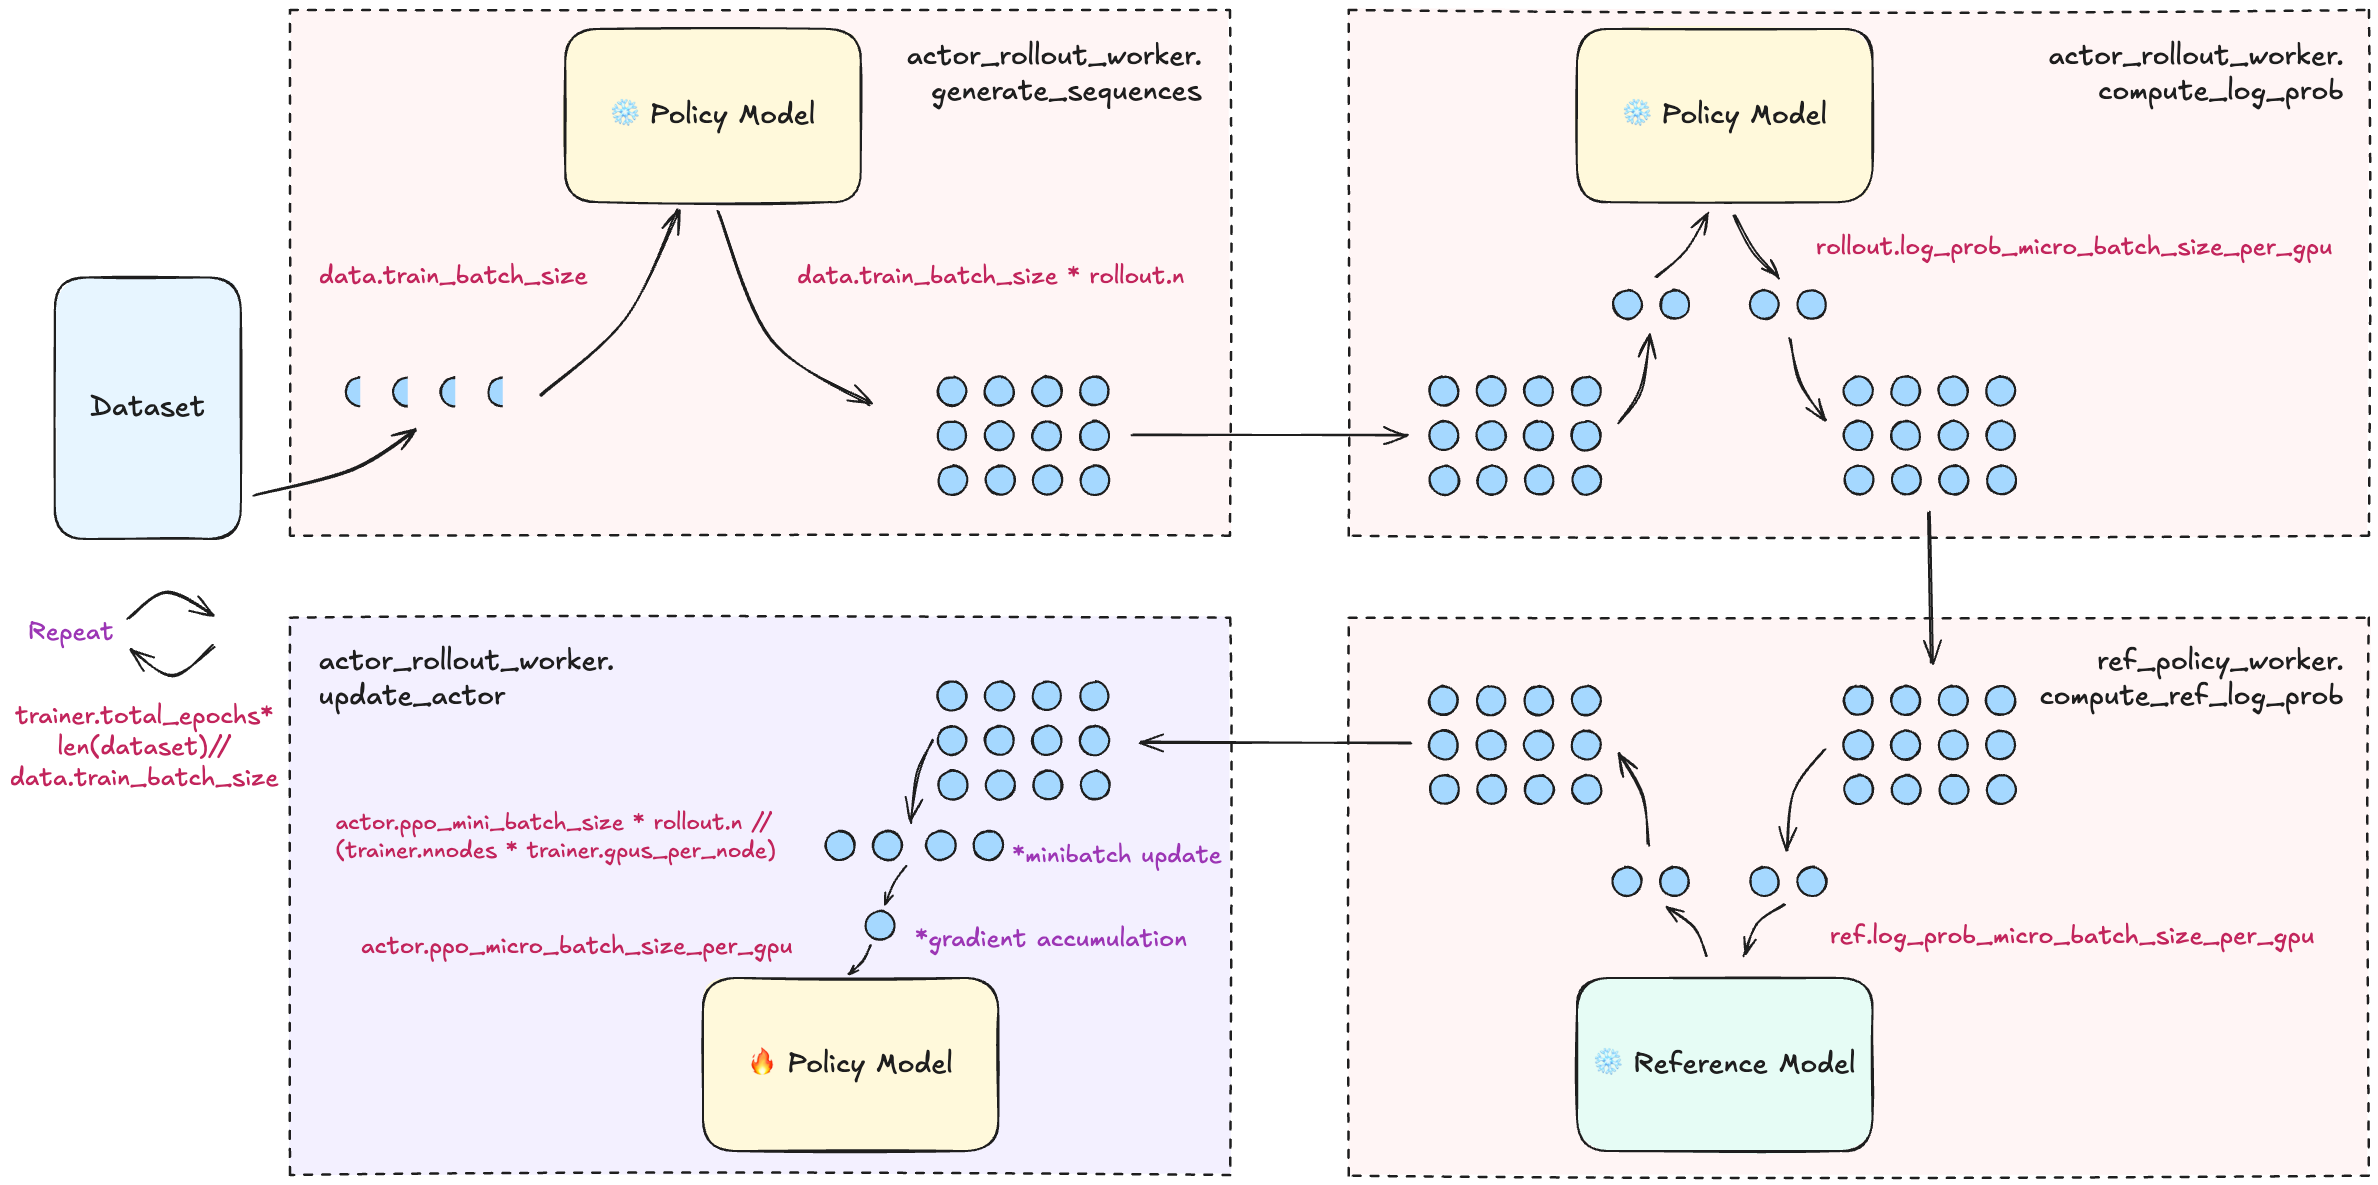

## 11.9 小结

本章系统梳理了强化微调（Reinforcement Learning Fine-Tuning, RLFT）在提升大语言模型推理能力中的理论基础与实践路径。我们首先分析了传统有监督微调（SFT）在复杂推理任务中面临的瓶颈，阐明了强化学习方法“奖励驱动、目标对齐”的独特优势。随后，通过将文本生成过程建模为马尔可夫决策过程（MDP），为强化微调在自然语言任务中的应用奠定了理论基础。

在奖励函数设计方面，章节总结了从直接反馈（如答案正确性）到更复杂的奖励建模和合成奖励的多种实践，强调了奖励信号对于模型能力塑造的核心作用。针对推理类任务的特殊需求，本章详细介绍了PPO、GRPO、DAPO和VAPO等主流强化微调算法，比较了各自的原理、收敛特性与适用场景。

此外，章节还深入探讨了奖励建模、合成数据生成等前沿技术在提升训练效率和泛化能力中的应用价值，并结合实际工程经验，分享了实现流程、常见问题与调参技巧，帮助读者跨越理论与落地之间的鸿沟。

综上所述，强化微调作为提升大模型推理与决策能力的关键环节，已经成为构建高效、智能AI系统不可或缺的技术基础。未来，随着算法与硬件的持续演进，强化微调将在更加广泛的推理、规划和复杂任务场景中展现更大潜力。

## 11.10 参考习题

### 习题 1

关于强化微调（Reinforcement Fine-Tuning, RFT）相比有监督微调（SFT）的优势，下列说法正确的是？

A. 强化微调无需任何奖励信号，训练全程只依赖标注数据。  
B. 强化微调可以通过奖励信号动态优化策略，提升模型推理能力。  
C. SFT 在复杂推理任务中的表现总是优于 RFT。  
D. 强化微调只适用于图像生成任务。

**参考答案**：B。

**解析**：强化微调的关键在于引入奖励信号（如推理正确与否），允许模型根据实际表现不断调整行为策略，尤其在需要复杂推理、反馈明确的场景下，比SFT更能提升性能。

### 习题 2

在将文本生成任务建模为马尔可夫决策过程（MDP）时，下列哪项描述最准确？

A. 动作是指模型选择每一步生成的下一个词（token）。  
B. 奖励只能在生成文本结束后统一给出，不能在中途给。  
C. 状态仅包括模型参数本身。  
D. MDP 建模与强化学习无关。

**参考答案**：A。

**解析**：在文本生成MDP建模中，“状态”通常指当前已生成的上下文，“动作”是模型生成的下一个token，“奖励”可以根据生成结果设计并分步反馈。A项正确。

### 习题 3

关于强化微调奖励函数的设计，下列说法正确的是？

A. 奖励函数必须非常复杂才能提升模型性能。  
B. 奖励可以直接以推理结果是否正确为依据，简单明了。  
C. 奖励与模型输出内容无关。  
D. 只要奖励为正，设计方式无关紧要。

**参考答案**：B。

**解析**：奖励函数应直观反映任务目标。例如，推理任务奖励可直接依据结果正误。无需复杂设计，明确反馈有助于模型学习正确行为。

### 习题 4

请简述强化微调在提升大语言模型推理能力方面的原理。为什么奖励信号的引入能够改善模型的推理表现？

**参考答案**：  
强化微调通过引入奖励信号，将模型的输出与任务目标（如推理正确性）直接对齐。模型通过与环境的交互、不断试错，在奖励信号的指导下优化决策策略。这样，模型不仅依赖训练数据，还能主动探索更优解，有效提升推理能力。

**解析**：奖励信号提供了明确的反馈，帮助模型区分“好”与“坏”的输出。不断地基于奖励调整策略，有助于模型克服监督学习面临的样本稀疏等难题，促进复杂推理能力的形成。其实在主流学术领域，无论是从价值导向还是策略导向出发，无论是单智能体还是多智能体场景，强化学习的核心目标始终是促使智能体在其所处环境中进行交互与行动，以实现奖励的最大化。而所有目标均可通过设计相应的奖励机制来表达。当智能体在实现和追求某一目标的过程中，其智能水平以及与该目标相关联的能力会得到隐式的提升，并且这种提升会在奖励的获取过程中得到显式的体现。希望同学们在回看以上强化学习发展历程和学习接下来的各类强化学习相关算法时，深刻理解奖励机制在引导智能体行为和提升智能体智能水平中的关键作用。

### 习题 5

本章代码已提供主流强化微调算法的实现。请尝试以下扩展实验：

- 调整clip参数（如clip上/下限），比较不同设置对训练过程和推理准确率的影响。
- 修改折扣因子gamma，观察其对训练收敛速度和模型最终性能的影响。
- 设计不同类型的奖励函数（如全或无奖励、部分奖励、负奖励、密集奖励等），对比分析模型输出行为、收敛情况和训练曲线的变化。
- （选做）可尝试修改batch size、学习率或loss中的entropy正则化项等，进一步探究其对模型表现的影响。

请通过实际运行和可视化，简要总结你的实验现象与结论。

**参考答案（思路）**：  
可发现clip参数影响更新幅度与训练稳定性，gamma调节模型对长期/短期回报的关注，奖励函数不同会导致agent收敛到完全不同的行为策略。更大的batch size和适当的entropy奖励有时能提升泛化和探索能力。具体规律需结合实验观察。



## 参考文献

- Mnih, V., Kavukcuoglu, K., Silver, D., Graves, A., Antonoglou, I., Wierstra, D., & Riedmiller, M. (2013). **Playing Atari with Deep Reinforcement Learning**. _arXiv preprint arXiv:1312.5602_.

- van Hasselt, H., Guez, A., & Silver, D. (2015). **Deep Reinforcement Learning with Double Q-learning**. _arXiv preprint arXiv:1509.06461_.

- Wang, Z., Schaul, T., Hessel, M., van Hasselt, H., Lanctot, M., & de Freitas, N. (2015). **Dueling Network Architectures for Deep Reinforcement Learning**. _arXiv preprint arXiv:1511.06581_.

- Lillicrap, T. P., Hunt, J. J., Pritzel, A., Heess, N., Erez, T., Tassa, Y., Silver, D., & Wierstra, D. (2015). **Continuous control with deep reinforcement learning**. _arXiv preprint arXiv:1509.02971_.

- Schulman, J., Moritz, P., Levine, S., Jordan, M., & Abbeel, P. (2015). **High-Dimensional Continuous Control Using Generalized Advantage Estimation**. _arXiv preprint arXiv:1506.02438_.

- Schulman, J., Wolski, F., Dhariwal, P., Radford, A., & Klimov, O. (2017). **Proximal Policy Optimization Algorithms**. _arXiv preprint arXiv:1707.06347_.

- Konda, V., & Tsitsiklis, J. (1999). **Actor-Critic Algorithms**. _Advances in Neural Information Processing Systems_, 12, 1008–1014. [Paper](https://proceedings.neurips.cc/paper_files/paper/1999/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf).

- Haarnoja, T., Zhou, A., Abbeel, P., & Levine, S. (2018). **Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor**. _arXiv preprint arXiv:1801.01290_.

- Sutton, R. S., McAllester, D., Singh, S., & Mansour, Y. (1999). **Policy Gradient Methods for Reinforcement Learning with Function Approximation**. _Advances in Neural Information Processing Systems_, 12, 1057–1063. [Paper](https://proceedings.neurips.cc/paper_files/paper/1999/file/464d828b85b0bed98e80ade0a5c43b0f-Paper.pdf).

- Shao, Z., Wang, P., Zhu, Q., Xu, R., Song, J., Bi, X., Zhang, H., Zhang, M., Li, Y. K., Wu, Y., & Guo, D. (2024). **DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models**. _arXiv preprint arXiv:2402.03300_.

- Yu, Q., Zhang, Z., Zhu, R., Yuan, Y., Zuo, X., Yue, Y., ... Wang, M. (2025). **DAPO: An Open-Source LLM Reinforcement Learning System at Scale**. _arXiv preprint arXiv:2503.14476_.

- Yue, Y., Yuan, Y., Yu, Q., Zuo, X., Zhu, R., Xu, W., ... Wang, M. (2025). **VAPO: Efficient and Reliable Reinforcement Learning for Advanced Reasoning Tasks**. _arXiv preprint arXiv:2504.05118_.

- Weng, L. (2024). **Reward Hacking in Reinforcement Learning**. _Lilian Weng’s Blog_. https://lilianweng.github.io/posts/2024-11-28-reward-hacking

- Ng, A. Y., & Russell, S. (2000). **Algorithms for Inverse Reinforcement Learning**. _ICML 2000_. https://ai.stanford.edu/~ang/papers/icml00-irl.pdf

- Gao, L., Schulman, J., & Hilton, J. (2022). **Scaling Laws for Reward Model Overoptimization**. _arXiv preprint arXiv:2210.10760_.

- Ouyang, L., Wu, J., Jiang, X., Almeida, D., Wainwright, C. L., Mishkin, P., Zhang, C., Agarwal, S., Slama, K., Ray, A., Schulman, J., Hilton, J., Kelton, F., Miller, L., Simens, M., Askell, A., Welinder, P., Christiano, P., Leike, J., & Lowe, R. (2022). **Training language models to follow instructions with human feedback**. _arXiv preprint arXiv:2203.02155_.

- Liao, J., Wen, M., & Wang, J., & Zhang, W. (2025). **MARFT: Multi-Agent Reinforcement Fine-Tuning**. _arXiv preprint arXiv:2504.16129_.

- Wen, M., Wan, Z., Zhang, W., Wang, J., & Wen, Y. (2024). **Reinforcing Language Agents via Policy Optimization with Action Decomposition**. _arXiv preprint arXiv:2405.15821_.

- Carta, T., Romac, C., Wolf, T., Lamprier, S., Sigaud, O., & Oudeyer, P.-Y. (2023). **Grounding Large Language Models in Interactive Environments with Online Reinforcement Learning**. _arXiv preprint arXiv:2302.02662_.

- OpenAI. (2023). **GPT-4 Technical Report**. _arXiv preprint arXiv:2303.08774_.
